In [72]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder
sns.set(rc={'figure.figsize':(12,8)})
pd.options.display.max_rows=None


In [73]:
#titles = ['Mr','Miss','Mrs','Jr','Dr','Rev','Master','Major',,,'Jonkheer','Don','Col','Capt','Countess']
titles = ['Mrs','Mr','Miss','Master','Mme','Mlle','Ms','Major','Jonkheer','Don','Col','Capt','Countess']
def get_title(name,title=titles):
    if any(t in name for t in title):
        for tt in title:
            if name.find(tt) != -1:
                if tt in ['Mme','Mlle','Ms']:
                    return 'Miss'
                elif tt in ['Major','Jonkheer','Don','Col','Capt','Countess']:
                    return 'Royal'
                else:
                    return tt
    else:
        return 'Other'
    

    
def extract_cabin(cabin):
    if cabin == cabin:
        return 'Yes'
    else:
        return 'No'    
    

def single_status(family_size):
    if family_size == 0:
        return 1
    else:
        return 0
    
def get_fair_per_person(data):
    if data.Total_Members == 0:
        return data.Fare
    else:
        return int(data.Fare/(data.Total_Members+1))


# Data Preprocessing Train Data

In [74]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [75]:
q_1,q_3  = np.percentile(train_df[train_df.Age.notnull()].Age,q=[25,75])
iqr = q_3-q_1
upper_bound = q_3 + 1.5*iqr

In [76]:
train_df = train_df[train_df.Age < 66]

In [77]:
dataset = [train_df,test_df]

In [78]:
for data in dataset:
    data['Cabin_Provided'] = data['Cabin'].apply(extract_cabin)
    data['Title'] = data['Name'].apply(get_title)


In [79]:
train_df.isna().sum()

PassengerId         0
Survived            0
Pclass              0
Name                0
Sex                 0
Age                 0
SibSp               0
Parch               0
Ticket              0
Fare                0
Cabin             524
Embarked            2
Cabin_Provided      0
Title               0
dtype: int64

In [80]:
age_details = train_df.groupby(['Sex','Title']).Age.median()

In [81]:
from scipy import stats

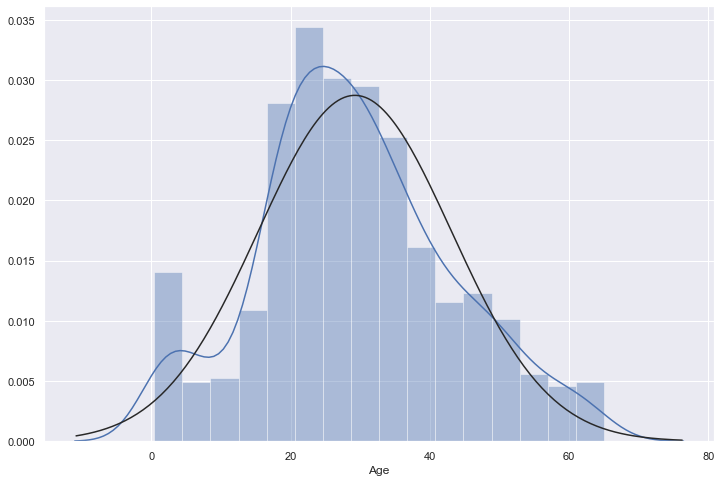

In [82]:
sns.distplot(train_df['Age'],fit=stats.norm)

In [83]:
train_df.groupby(['Title','Survived']).Age.describe()

count       mean        std    min    25%   50%    75%   max
Title  Survived                                                              
Master 0          15.0   5.400000   3.480558   1.00   2.00   4.0   8.50  11.0
       1          21.0   3.984286   3.684320   0.42   1.00   3.0   6.00  12.0
Miss   0          40.0  18.725000  11.604017   2.00   9.00  18.0  24.25  50.0
       1         107.0  23.018692  13.287580   0.75  16.00  22.0  30.00  63.0
Mr     0         325.0  31.526154  11.969551  11.00  22.00  29.0  38.00  65.0
       1          67.0  32.582090  10.117715  16.00  26.00  31.0  37.50  62.0
Mrs    0          24.0  35.583333   9.712908  18.00  27.75  35.5  43.25  57.0
       1          88.0  35.659091  11.998933  14.00  26.50  35.0  44.25  63.0
Other  0           9.0  42.222222  13.131810  23.00  28.00  44.0  54.00  57.0
       1           3.0  43.666667  10.115994  32.00  40.50  49.0  49.50  50.0
Royal  0           4.0  45.750000   9.945686  38.00  39.50  42.5  48.75  60.0
       1           3.0  47.000000  12.288206  33.00  42.50  52.0  54.00  56.0

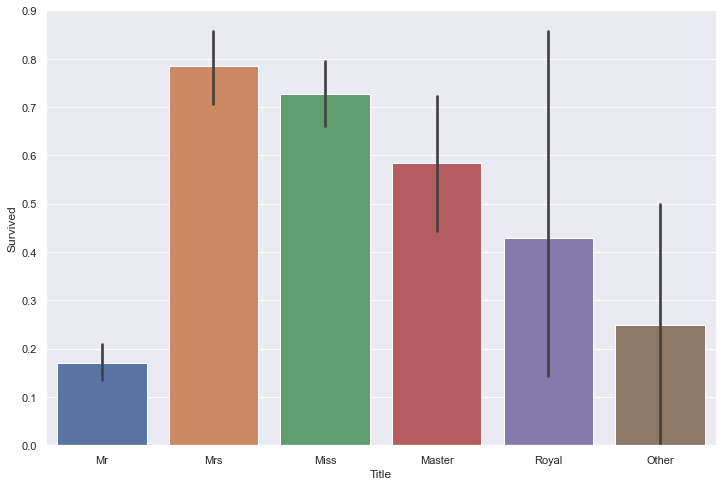

In [84]:
sns.barplot(x='Title',y='Survived',data=train_df)

In [85]:
train_df[(train_df.Title == 'Mr') & (train_df.Survived == 1)].shape[0]/train_df[(train_df.Title == 'Mr')].shape[0]

0.17091836734693877

In [86]:
def transform_age(dataset,age_details=age_details):
    ages = []
    for i,Age in enumerate(dataset['Age']):
        if not math.isnan(Age):
            ages.append(Age)
        else:
            ages.append(age_details[dataset.Sex[i]][dataset.Title[i]].round(1))
    return ages
          
            

In [88]:
bins = [0,1,5,12,19,25,35,45,60,100]

In [89]:
temp = pd.cut(train_df.Age,bins,labels=[1,2,3,4,5,6,7,8,9],right=False,include_lowest=True)

In [90]:
for data in dataset:
    data['Age'] = transform_age(data)
    #data['Age'] = data['Age'].astype(int)
    data['Age_Group'] = pd.cut(data.Age,bins,labels=[1,2,3,4,5,6,7,8,9],right=False,include_lowest=True)

In [91]:
import matplotlib.pyplot as plt

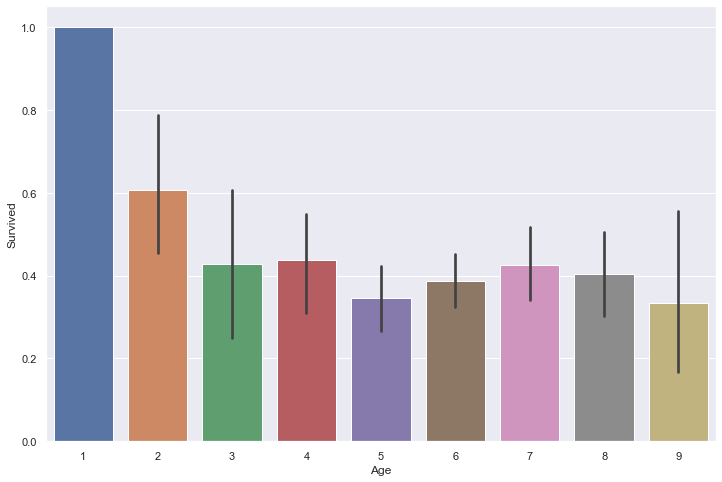

In [92]:
sns.barplot(x=temp,y=train_df['Survived'])

#sns.factorplot(x='Parch',y='Survived',hue='Sex',data=train_df)

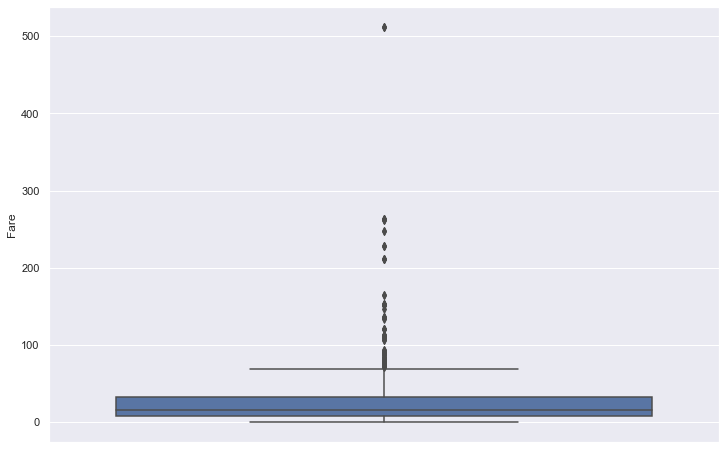

In [93]:
sns.boxplot(train_df['Fare'],orient='v')
q_1,q_3  = np.percentile(data[data.Fare.notnull()].Age,q=[25,75])
iqr = q_3-q_1
upper_bound = q_3 + 1.5*iqr

In [94]:
train_df[train_df.Fare > upper_bound]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Provided,Title,Age_Group
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,Yes,Mrs,7
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,Yes,Mr,5
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.00,1,0,PC 17604,82.1708,NaN,C,No,Mr,6
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.00,1,0,PC 17572,76.7292,D33,C,Yes,Mrs,8
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.00,0,1,113509,61.9792,B30,C,Yes,Mr,9
61,62,1,1,"Icard, Miss. Amelie",female,38.00,0,0,113572,80.0000,B28,NaN,Yes,Miss,7
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.00,1,0,36973,83.4750,C83,S,Yes,Mr,8
72,73,0,2,"Hood, Mr. Ambrose Jr",male,21.00,0,0,S.O.C. 14879,73.5000,NaN,S,No,Mr,5
74,75,1,3,"Bing, Mr. Lee",male,32.00,0,0,1601,56.4958,NaN,S,No,Mr,6
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,Yes,Miss,5


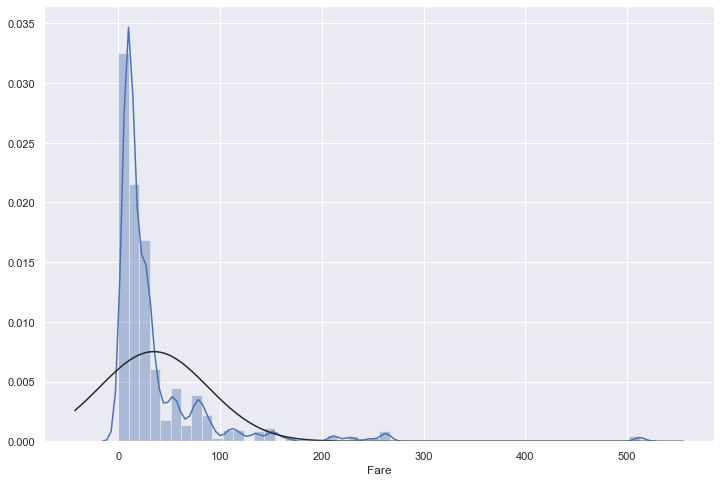

In [95]:
sns.distplot(train_df['Fare'].dropna(axis=0),fit=stats.norm)


In [96]:
data['Fare'].median()

14.4542

In [97]:
pd.cut(np.log10(train_df['Fare'].dropna(axis=0).values+1),4)

[(0.678, 1.355], (1.355, 2.033], (0.678, 1.355], (1.355, 2.033], (0.678, 1.355], ..., (1.355, 2.033], (0.678, 1.355], (1.355, 2.033], (1.355, 2.033], (0.678, 1.355]]
Length: 706
Categories (4, interval[float64]): [(-0.00271, 0.678] < (0.678, 1.355] < (1.355, 2.033] < (2.033, 2.71]]

In [98]:
 pd.qcut(train_df['Fare'],4,labels = [1, 2, 3, 4])

0      1
1      4
2      1
3      4
4      1
6      4
7      3
8      2
9      3
10     3
11     3
12     1
13     3
14     1
15     3
16     3
18     3
20     3
21     2
22     1
23     4
24     3
25     3
27     4
30     3
34     4
35     4
37     1
38     3
39     2
40     2
41     3
43     4
44     1
49     3
50     4
51     1
52     4
53     3
54     4
56     2
57     1
58     3
59     4
60     1
61     4
62     4
63     3
66     2
67     2
68     1
69     2
70     2
71     4
72     4
73     2
74     4
75     1
78     3
79     2
80     2
81     2
83     4
84     2
85     3
86     4
88     4
89     1
90     1
91     1
92     4
93     3
94     1
97     4
98     3
99     3
100    1
102    4
103    2
104    1
105    1
106    1
108    1
110    4
111    2
112    1
113    2
114    2
115    1
117    3
118    4
119    3
120    4
122    3
123    2
124    4
125    2
127    1
129    1
130    1
131    1
132    2
133    3
134    2
135    2
136    3
137    4
138    2
139    4
141    1
142    3
1

In [99]:
for data in dataset:
    data['Fare'] = data['Fare'].fillna(data['Fare'].median())
    data['Fare'] = np.log10(data['Fare'].values+1)
    data['Fare_Group'] = pd.qcut(data['Fare'],4,labels = [1, 2, 3, 4])
    data['Total_Members'] = data['SibSp']+data['Parch']
    #data['Fare'] = data['Fare'].astype(int)
    #data['Age_Group'] = data['Age'].apply(get_age_group)
    data['Age_Class'] = data['Pclass']*data['Age']
    data['fare_per_person'] = data.apply(get_fair_per_person,axis=1)
    data['Alone'] = data['Total_Members'].apply(single_status)
    data['Embarked'] = data['Embarked'].fillna(method='ffill')
  
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Provided,Title,Age_Group,Fare_Group,Total_Members,Age_Class,fare_per_person,Alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,0.916454,NaN,S,No,Mr,5,1,1,66.0,0.000000,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,1.859038,C85,C,Yes,Mrs,7,4,1,38.0,0.000000,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,0.950608,NaN,S,No,Miss,6,1,0,78.0,0.950608,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,1.733197,C123,S,Yes,Mrs,7,4,1,35.0,0.000000,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,0.956649,NaN,S,No,Mr,7,1,0,105.0,0.956649,1


In [100]:
train_df = train_df.drop(['Ticket','Name','Cabin'],axis=1)
test_df = test_df.drop(['Ticket','Name','Cabin'],axis=1)

In [101]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Provided,Title,Age_Group,Fare_Group,Total_Members,Age_Class,fare_per_person,Alone
0,1,0,3,male,22.0,1,0,0.916454,S,No,Mr,5,1,1,66.0,0.000000,0
1,2,1,1,female,38.0,1,0,1.859038,C,Yes,Mrs,7,4,1,38.0,0.000000,0
2,3,1,3,female,26.0,0,0,0.950608,S,No,Miss,6,1,0,78.0,0.950608,1
3,4,1,1,female,35.0,1,0,1.733197,S,Yes,Mrs,7,4,1,35.0,0.000000,0
4,5,0,3,male,35.0,0,0,0.956649,S,No,Mr,7,1,0,105.0,0.956649,1


In [102]:
test_df['Fare_Group'].value_counts()

1    114
4    105
3    102
2     97
Name: Fare_Group, dtype: int64

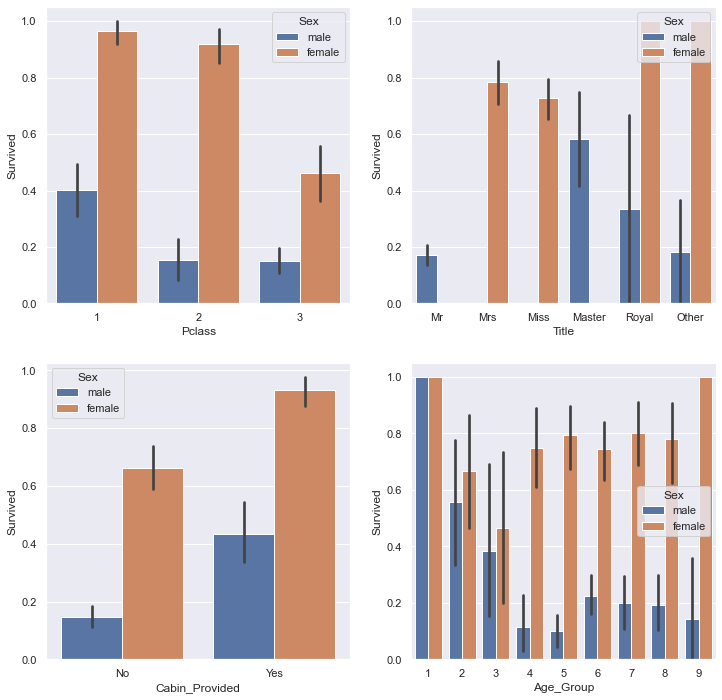

In [103]:
fig,ax = plt.subplots(2,2,figsize=(12, 12))
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=train_df,ax=ax[0,0])
sns.barplot(x='Title',y='Survived',hue='Sex',data=train_df,ax=ax[0,1])
sns.barplot(x='Cabin_Provided',y='Survived',hue='Sex',data=train_df,ax=ax[1,0])
sns.barplot(x='Age_Group',y='Survived',hue='Sex',data=train_df,ax=ax[1,1])

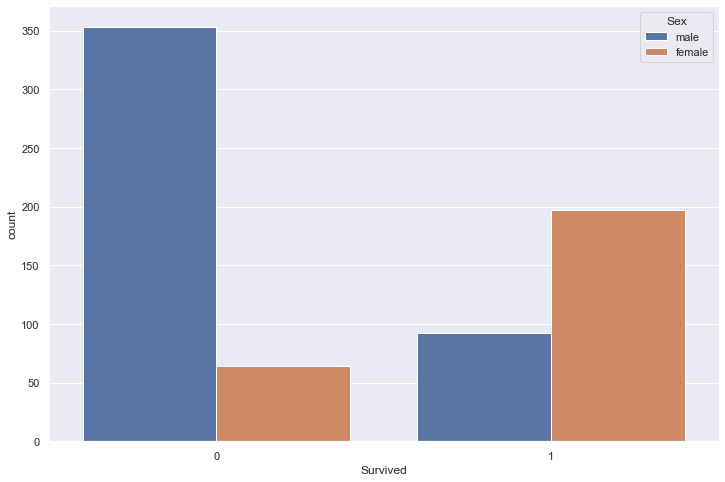

In [104]:
sns.countplot(x='Survived',hue='Sex',data=train_df)

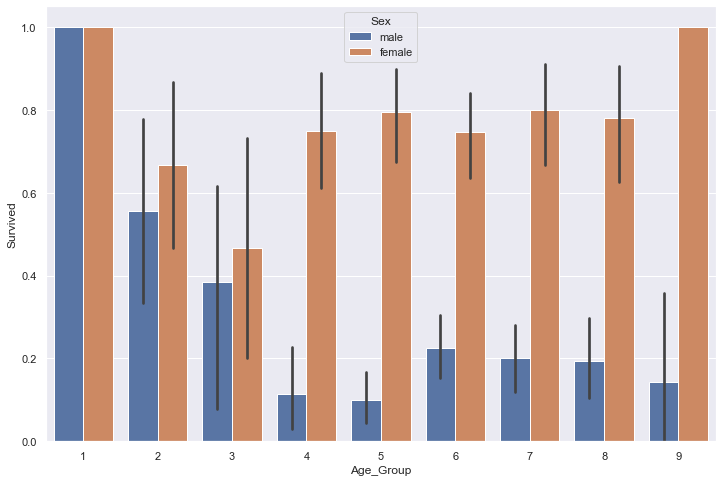

In [105]:
sns.barplot(x='Age_Group',y='Survived',hue='Sex',data=train_df)

In [116]:
train_df[(train_df.Age_Group == 6) & (train_df.Sex == 1) & (train_df.Survived == 1)]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Provided,Title,Age_Group,Fare_Group,Total_Members,Age_Class,fare_per_person,Alone
21,22,1,2,1,34.0,0,0,1.146128,1,1,1,6,2,0,68.0,1.146128,1
23,24,1,1,1,28.0,0,0,1.562293,1,1,1,6,4,0,28.0,1.562293,1
74,75,1,3,1,32.0,0,0,1.759636,1,0,1,6,4,0,96.0,1.759636,1
81,82,1,3,1,29.0,0,0,1.021189,1,0,1,6,2,0,87.0,1.021189,1
146,147,1,3,1,27.0,0,0,0.944275,1,0,1,6,1,0,81.0,0.944275,1
207,208,1,3,1,26.0,0,0,1.296391,2,0,1,6,3,0,78.0,1.296391,1
267,268,1,3,1,25.0,1,0,0.943247,1,0,1,6,1,1,75.0,0.000000,0
271,272,1,3,1,25.0,0,0,0.000000,1,0,1,6,1,0,75.0,0.000000,1
286,287,1,3,1,30.0,0,0,1.021189,1,0,1,6,2,0,90.0,1.021189,1
370,371,1,1,1,25.0,1,0,1.751600,2,1,1,6,4,1,25.0,0.000000,0


In [107]:
test_df['Title'].value_counts()

Mr        240
Miss       79
Mrs        72
Master     21
Royal       3
Other       3
Name: Title, dtype: int64

In [108]:
train_df.groupby(['Sex','Title','Survived']).Age_Group.describe()

count  unique  top  freq
Sex    Title  Survived                          
female Miss   0            40       7    5     9
              1           107       9    6    24
       Mrs    0            24       5    6    10
              1            88       6    7    23
       Other  1             1       1    8     1
       Royal  1             1       1    6     1
male   Master 0            15       2    2     8
              1            21       4    2    10
       Mr     0           325       7    6   105
              1            67       6    6    30
       Other  0             9       4    8     4
              1             2       2    8     1
       Royal  0             4       3    7     2
              1             2       1    8     2

In [109]:
dataset = [train_df,test_df]

In [110]:
embarked = {'S':1, 'C':2, 'Q':3}
sex = {'male':1,'female':2}
#cabin_codes = {'No_Cabin':0, 'C':1, 'E':2, 'G':3, 'D':4, 'A':5, 'B':6, 'F':7, 'T':8}
Cabin_Provided={'No':0,'Yes':1}
Title = {'Mr':1,'Miss':2,'Mrs':3,'Master':4,'Royal':5,'Other':6}

for data in dataset:
    #print(data.head())
    data.Sex = data.Sex.map(sex)
    data.Embarked = data.Embarked.map(embarked)
    data.Cabin_Provided = data.Cabin_Provided.map(Cabin_Provided)
    data.Title = data.Title.map(Title)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_Provided,Title,Age_Group,Fare_Group,Total_Members,Age_Class,fare_per_person,Alone
0,1,0,3,1,22.0,1,0,0.916454,1,0,1,5,1,1,66.0,0.000000,0
1,2,1,1,2,38.0,1,0,1.859038,2,1,3,7,4,1,38.0,0.000000,0
2,3,1,3,2,26.0,0,0,0.950608,1,0,2,6,1,0,78.0,0.950608,1
3,4,1,1,2,35.0,1,0,1.733197,1,1,3,7,4,1,35.0,0.000000,0
4,5,0,3,1,35.0,0,0,0.956649,1,0,1,7,1,0,105.0,0.956649,1


In [111]:
train_df.to_csv('train_1.csv',index=False)
test_df.to_csv('test_1.csv',index=False)

# Analysis

In [112]:
corr = train_df.corr()

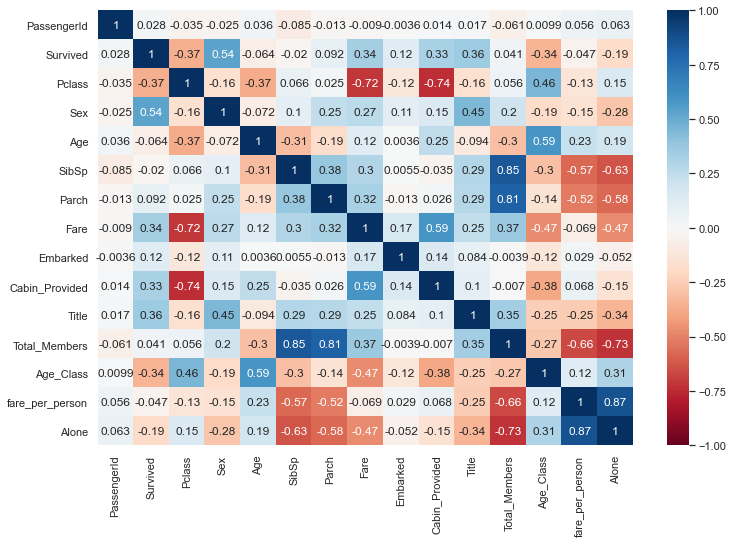

In [113]:
sns.heatmap(corr,annot=True,vmin=-1,vmax=1,cmap='RdBu')

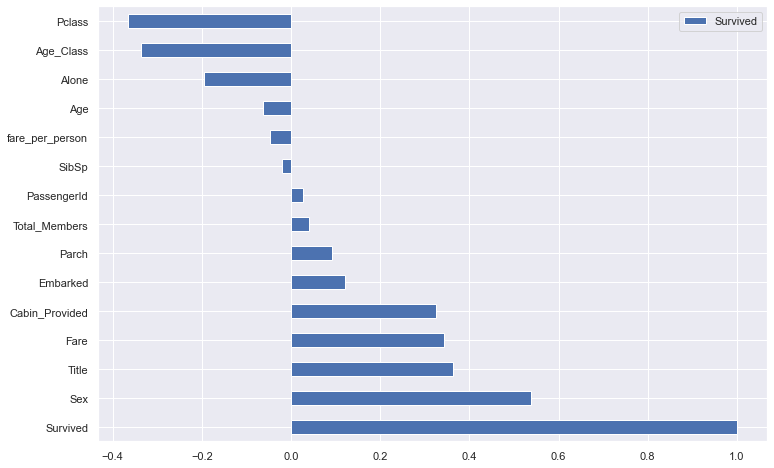

In [114]:
corr[['Survived']].sort_values(by='Survived',ascending=False,).plot(kind='barh')

In [ ]:
train_df.so